Imports

In [34]:
import tensorflow as tf
from PIL import Image
from PIL import ImageDraw, ImageFont

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import pandas as pd
import colorsys

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import add
from keras.layers import concatenate
from keras.models import Model
import struct
import cv2
from copy import deepcopy

Fetch Data

GPU

In [35]:
# device_name = tf.test.gpu_device_name()
# if(device_name != "/device:GPU:0"):
#     raise SystemError("GPU Device Not Found")
# print(f"Found GPU at {device_name}")

Defining Anchor Boxes

In [36]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]

Defining Class Labels

In [37]:
lbls = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Loading Image

720 400


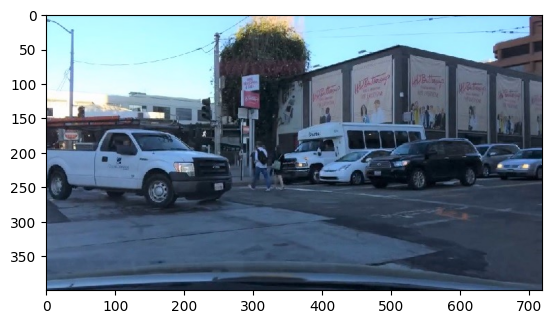

In [38]:
img_path = "data/image.jpg"

img_pil = Image.open(img_path)
img_w, img_h = img_pil.size

print(img_w, img_h)
plt.imshow(img_pil)
plt.show()

DarkNet's input size is (416,416) so preprocess

In [39]:
def preprocess_input(img_pil, net_h, net_w):
    img = np.asarray(img_pil)
    new_h, new_w, _ = img.shape

    if(float(net_w) / new_w) < (float(net_h) / new_h):
        new_h = (new_h * net_w) / new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h) / new_h
        new_h = net_h

    resized = cv2.resize(img / 255., (int(new_w), int(new_h)))

    new_img = np.ones((net_h, net_w, 3)) * 0.5
    new_img[int((net_h - new_h) // 2):int((net_h + new_h) // 2), int((net_w - new_w) // 2):int((net_w + new_w) // 2), :] = resized
    new_img = np.expand_dims(new_img, 0)

    return new_img

Detection Kernel size is 1 x 1 x 255

1 x 1 x (B x (1 + 4 + C))
    - 1 x 1 means the kernel only looks at 1 cell at a time
    - 4 is for 4 bounding box traits
    - 1 is for confidence
    - C = 80 object categories
    - B  = 3 anchor boxes

Loading Model

In [40]:
import tensorflow as tf

model_path = "yolo.h5"
darknet = tf.keras.models.load_model(model_path)

Forward Pass


In [41]:
# yolo_output = darknet.predict(new_img)
# print(len(yolo_output))
# print(yolo_output[0].shape)
# print(yolo_output[1].shape)
# print(yolo_output[2].shape)

Post-Processing

Sigmoid

In [42]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

Bounding Box

In [43]:
class BoundingBox:
    def __init__(self, x_min, y_min, x_max, y_max, obj_conf = None, classes = None):
        self.xmin = x_min
        self.ymin = y_min
        self.xmax = x_max
        self.ymax = y_max

        self.objness = obj_conf
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

Correcting Yolo Boxes

In [44]:
def correct_boxes(boxes_, img_h, img_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/img_w) < (float(net_h)/img_h):
        new_w = net_w
        new_h = (img_h*net_w)/img_w
    else:
        new_h = net_w
        new_w = (img_w*net_h)/img_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * img_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * img_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * img_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * img_h)
    return boxes

Filtering Bounding Boxes

In [45]:
def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = sigmoid(netout[..., :2])
      netout[..., 4:]  = sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundingBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

Bounding Box Overlap Detection

In [46]:
def interval_overlap(inter_a, inter_b):
    x1, x2 = inter_a
    x3, x4 = inter_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3


def bound_box_overlap(box1, box2):
    inter_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    inter_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = inter_w * inter_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union = w1 * h1 + w2 * h2 - intersect

    return float(intersect) / union

Non-Maximal Suppression 

In [47]:
def nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return
    
    for c in range(num_class):
        sorted_index = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_index)):
            ind_i = sorted_index[i]

            if boxes[ind_i].classes[c] == 0:
                continue

            for j in range(i + 1, len(sorted_index)):
                ind_j = sorted_index[j]

                if bound_box_overlap(boxes[ind_i], boxes[ind_j]) >= nms_thresh:
                    boxes[ind_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)
    
    return new_boxes


Draws Given Bounding Boxes with Labels

In [48]:
def draw_boxes(img_, boxes, labels):
    img = img_.copy()
    img_w, img_h = img.size
    font = ImageFont.truetype(font = "LiberationMono-Regular.ttf", size = np.floor(3e-2 * img_h + 0.5).astype("int32"))
    thick = (img_w + img_h) // 300

    #Generating colors for drawing bounding boxes
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    np.random.seed(10101) #Consistent colors
    np.random.shuffle(colors) #Decorrelation
    np.random.seed(None)

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        pred_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        lbl = '{} {:.2f}'.format(pred_class, score)
        draw = ImageDraw.Draw(img)
        lbl_sz = draw.textsize(lbl, font)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(img_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(img_w, np.floor(right + 0.5).astype('int32'))

        print(lbl, (left, top), (right, bottom))

        if top - lbl_sz[1] >= 0:
            txt_orig = np.array([left, top - lbl_sz[1]])
        else:
            txt_orig = np.array([left, top + 1])

        for i in range(thick):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])

        draw.rectangle([tuple(txt_orig), tuple(txt_orig + lbl_sz)], fill=colors[c])
        draw.text(txt_orig, lbl, fill=(0,0,0), font=font)

        del draw
    
    return img

Wrapper Function to preprocess, predict, and post-process

In [49]:
def img_det(img_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h = 416, net_w = 416, anchors = anchors, lbls = lbls):
    img_w, img_h = img_pil.size

    new_img = preprocess_input(img_pil, net_h, net_w)
    yolo_output = darknet.predict(new_img)

    boxes = decode_netout(yolo_output, obj_thresh, anchors, img_h, img_w, net_h, net_w)
    boxes = nms(boxes, nms_thresh, obj_thresh)

    img_det = draw_boxes(img_pil, boxes, lbls)

    return img_det

Showing Image

1/1 [==============================] - 2s 2s/step
car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


C:\Users\marag\AppData\Local\Temp\ipykernel_3920\3868409131.py:25: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  lbl_sz = draw.textsize(lbl, font)
C:\Users\marag\AppData\Local\Temp\ipykernel_3920\3868409131.py:25: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  lbl_sz = draw.textsize(lbl, font)
C:\Users\marag\AppData\Local\Temp\ipykernel_3920\3868409131.py:25: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  lbl_sz = draw.textsize(lbl, font)
C:\Users\marag\AppData\Local\Temp\ipykernel_3920\3868409131.py:25: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  lbl_sz = draw.textsize(lbl, font)
C:\Users\marag\AppData\Local\Temp\ipykernel_3920\3868409131.py:25: DeprecationWarnin

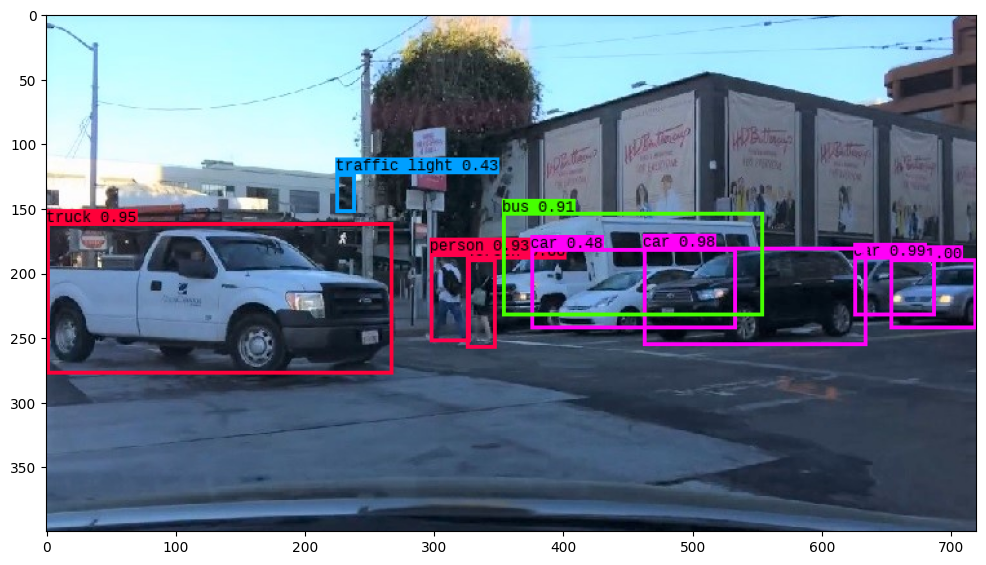

In [50]:
plt.figure(figsize=(12,12))
plt.imshow(img_det(img_pil))
plt.show()

Using OpenCV for Video Input

Convert OpenCV to PIL for detection, and back to OpenCV to write frames into new video

In [ ]:
def vid_det(vid_path, out_path, )